## Import necessary modules

In [1]:
from pathlib import Path
import pandas as pd
import librosa 
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
directory_path = Path('E:\DeepLearning\speech_recognition\Data\AI')
files_list = list(directory_path.glob('*'))
files_list = [file.name for file in files_list]

In [3]:
df_ai = pd.DataFrame(files_list)
df_ai['label']=1

In [5]:
df_ai.shape

(61, 2)

In [6]:
df_ai.columns = ['file', 'label']

In [8]:
df_ai.sample(5)

,file,label
27,recording_20240718T111633907Z.m4a,1
28,recording_20240718T111655013Z.m4a,1
41,recording_20240718T112618025Z.m4a,1
36,recording_20240718T112210964Z.m4a,1
3,AI12.m4a,1


In [10]:
files_list = list(Path('E:\DeepLearning\speech_recognition\Data\Person').glob('*'))
files_list = [file.name for file in files_list]

In [11]:
df_person = pd.DataFrame(files_list)
df_person['label']=0

In [13]:
df_person.columns = ['file', 'label']
df_person.shape

(61, 2)

In [14]:
df = pd.concat([df_ai, df_person], ignore_index=True)
df.shape

(122, 2)

In [15]:
df = df.sample(frac=1)

In [17]:
df.head()

,file,label
64,12.m4a,0
83,recording_20240718T104751420Z.m4a,0
49,recording_20240718T113452736Z.m4a,1
51,recording_20240718T113717758Z.m4a,1
52,recording_20240718T113739324Z.m4a,1


In [19]:
int(0.8*len(df))

97

In [20]:
train = df[:int(0.8*len(df))]
test = df[int(0.8*len(df)):]

In [21]:
X_train = train.drop('label', axis=1)
y_train = train['label']

X_test = test.drop('label', axis=1)
y_test = test['label']

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((97, 1), (97,), (25, 1), (25,))

In [113]:
# extract the feature of audio file

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    folder = Path('E:/DeepLearning/speech_recognition/uploads').resolve()
    file_name = folder / files.file
    

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name) 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        

    return mfccs, chroma, mel, contrast, tonnetz

In [25]:
X_train = X_train.apply(lambda x: extract_features(x), axis=1)
X_test = X_test.apply(lambda x: extract_features(x), axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_12792\3739421238.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  X, sample_rate = librosa.load(file_name)
e:\DeepLearning\deeplearning\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\user\AppData\Local\Temp\ipykernel_12792\3739421238.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  X, sample_rate = librosa.load(file_name)
e:\DeepLearning\deeplearning\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [36]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [35]:
X_train[0][4]

array([-0.02800882,  0.00679972, -0.01242764, -0.04691096,  0.02159409,
       -0.00012399])

In [37]:
def create_features(features_label):
    features = []
    for i in range(0, len(features_label)):
        features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                    features_label[i][2], features_label[i][3],
                    features_label[i][4]), axis=0))
    return features

In [38]:
Xtrain = create_features(X_train)
Xtest = create_features(X_test)

In [39]:
Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)

In [40]:
Xtrain.shape, Xtest.shape

((97, 193), (25, 193))

In [41]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [43]:
Xtrain.shape

(97, 193)

In [52]:
model = Sequential()

model.add(Dense(units=193, activation='relu', input_shape=(Xtrain.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

e:\DeepLearning\deeplearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 193)            │        37,442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 193)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,915 (308.26 KB)

 Trainable params: 78,915 (308.26 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [55]:
history = model.fit(Xtrain, y_train, epochs=30, batch_size=5, validation_data=(Xtest, y_test))

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.5943 - loss: 0.7989 - val_accuracy: 0.8800 - val_loss: 0.2529
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7688 - loss: 0.3950 - val_accuracy: 1.0000 - val_loss: 0.1231
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9201 - loss: 0.1711 - val_accuracy: 1.0000 - val_loss: 0.0589
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9661 - loss: 0.1216 - val_accuracy: 1.0000 - val_loss: 0.0322
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9694 - loss: 0.0916 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9870 - loss: 0.0646 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9968 - loss: 0.0405 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9810 - loss: 0.0351 - val_accuracy: 1.0000 - v

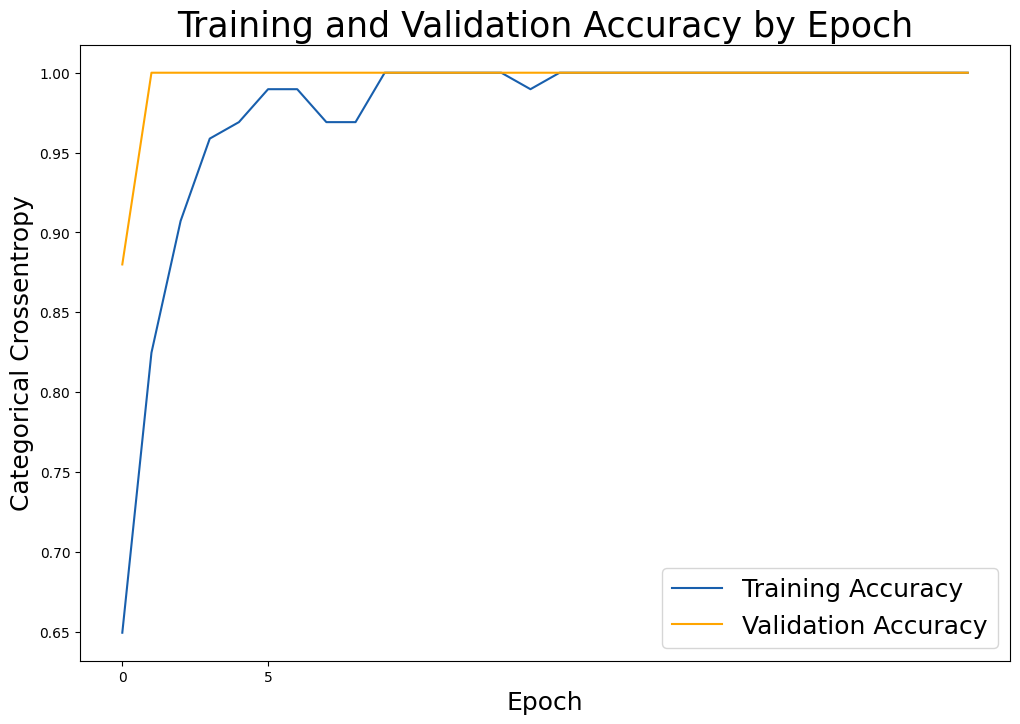

In [56]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,10,5), range(0,10,5))

plt.legend(fontsize = 18);

In [57]:
pred = model.predict(Xtest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


In [58]:
def label_prediction(x):
    if x > 0.5:
        return 'AI'
    else:
        return 'Person'

In [59]:
y_test

4      1
1      1
24     1
63     0
22     1
3      1
60     1
2      1
98     0
113    0
116    0
15     1
99     0
38     1
104    0
45     1
120    0
118    0
18     1
88     0
41     1
73     0
71     0
36     1
77     0
Name: label, dtype: int64

In [60]:
y_pred = model.predict(Xtest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [61]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


y_pred = [1 if x > 0.5 else 0 for x in y_pred]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))



[[12  0]
 [ 0 13]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

1.0


In [120]:
test ='recording_20240718T124813925Z.m4a'

In [121]:
def process_test(test):
    test = pd.DataFrame(test, columns=['file'])
    test = test.apply(extract_features, axis=1)
    test = np.array(test)
    test = create_features(test)
    test = np.array(test)
    test = scaler.transform(test)
    return test

In [122]:
def predict(test):
    test = process_test(test)
    pred = model.predict(test)
    return label_prediction(pred)

In [123]:
predict([test])

C:\Users\user\AppData\Local\Temp\ipykernel_12792\1125245415.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  X, sample_rate = librosa.load(file_name)
e:\DeepLearning\deeplearning\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


'Person'

In [103]:
test.shape

(1, 193)

In [104]:
pred = model.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [105]:
pred[0][0]

4.049029e-06

In [106]:
label_prediction(pred[0][0])

'Person'

In [85]:
# save the model for flask app
model.save('voice_model.h5')

In [86]:
import joblib

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']